## Predicting the price for an Airbnb Host in Berlin

Airbnb has successfully disrupted the traditional hospitality industry as more and more travelers decide to use Airbnb as their primary accommodation provider. Since its inception in 2008, Airbnb has seen an enormous growth, with the number of rentals listed on its website growing exponentially each year.

In Germany, no city is more popular than Berlin. That implies that Berlin is one of the hottest markets for Airbnb in Europe, with over 22,552 listings as of November 2018. With a size of 891 km², this means there are roughly 25 homes being rented out per km² in Berlin on Airbnb!

The following question will drive this project:

> **Can we determine a fairly spot-on daily price for a new accommodation that fits into its specific market environment and competitors in Berlin?** <br>

The question focuses on the accommodation features and decisions a new host can make with regards to initial presentation, i.e. posting a picture of him- or herself on the website, determining a minimum length of stay, offering instant bookings etc. A machine learning algorithm will be applied to try to get an answer. 

## Table of Contents
<a id='Table of contents'></a>

### <a href='#1. Obtaining and Viewing the Data'> 1. Obtaining and Viewing the Data </a>

### <a href='#2. Preprocessing the Data'> 2. Preprocessing the Data </a>
* <a href='#2.1. Deciding which columns to work with'> 2.1. Deciding which columns to work with </a>
* <a href='#2.2. Cleaning Price Columns'> 2.2. Cleaning Price Columns </a>
* <a href='#2.3. Dealing with Missing Values'> 2.3. Dealing with Missing Values </a>
* <a href='#2.4. Feature Engineering 1: Distance to Centroid of Berlin'> 2.4. Feature Engineering 1: Distance to Centroid of Berlin </a>
* <a href='#2.5. Feature Engineering 2: Lodging Size'> 2.5. Feature Engineering 2: Lodging Size </a>
* <a href='#2.6. Feature Engineering 3: Lodging Amenities'> 2.6. Feature Engineering 3: Lodging Amenities </a>

### <a href='#3. Exploratory Data Analysis (EDA)'> 3. Exploratory Data Analysis (EDA) </a>

### <a href='#4. Modeling the Data'> 4. Modeling the Data </a>
* <a href='#4.1. Preparing Target and Features'> 4.1. Preparing Target and Features </a>
* <a href='#4.2. Splitting and Scaling the Data'> 4.2. Splitting and Scaling the Data </a>
* <a href='#4.3. Training an XGBoost Regressor'> 4.3. Training an XGBoost Regressor </a>
* <a href='#4.4. Cross Validation'> 4.4. Cross Validation </a>

### <a href='#5. Interpreting the Data'> 5. Interpreting the Data </a>

### <a href='#6. Appendix'> 6. Appendix </a>

### 1. Obtaining and Viewing the Data 
<a id='1. Obtaining and Viewing the Data'></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import re
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_initial = pd.read_csv('./data/listings_summary.csv')

# checking shape
print("The dataset has {} rows and {} columns.".format(*df_initial.shape))

# ... and duplicates
print("It contains {} duplicates.".format(df_initial.duplicated().sum()))

The dataset has 22552 rows and 96 columns.
It contains 0 duplicates.


In [3]:
df_initial.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and U2 (metro), Trams M12, ...","Simple kitchen/cooking, refrigerator, microwav...",Always available,"No parties No events No pets No smoking, not e...",NaN,NaN,https://a0.muscache.com/im/pictures/260fd609-7...,NaN,2217,https://www.airbnb.com/users/show/2217,Ian,2008-08-18,"Key Biscayne, Florida, United States",Believe in sharing economy.,within an hour,96%,NaN,t,https://a0.muscache.com/im/pictures/21428a22-4...,https://a0.muscache.com/im/pictures/21428a22-4...,Mitte,4.0,4.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Mitte,Brunnenstr. Süd,...,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",NaN,$60.00,NaN,NaN,$200.00,$30.00,1,$28.00,4,1125,3 months ago,t,0,21,51,141,2018-11-07,118,2016-04-11,2018-10-28,93.0,10.0,9.0,10.0,10.0,10.0,9.0,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76


In [4]:
# check the columns we currently have
df_initial.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 2. Preprocessing the Data 
<a id='2. Preprocessing the Data'></a>

#### 2.1. Deciding which columns to work with 
<a id='2.1. Deciding which columns to work with'></a>

Let's imagine we are in the shoes of someone who'd like to offer their home. Fixed features of our property include its rooms, size, and location. We also can decide on how we want to be listed: with a picture or not, how many minimum nights we want a guest to stay, whether we are instantly bookable, how we handle cancellations, etc. But we can neither be a "super host", nor do we have any reviews yet to show - although they can be very important for setting a price. So, let's focus only on features we can influence:

In [5]:
# define the columns we want to keep
columns_to_keep = ['id', 'space', 'description', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'square_feet', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

df_raw = df_initial[columns_to_keep].set_index('id')
print("The dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*df_raw.shape))

The dataset has 22552 rows and 23 columns - after dropping irrelevant columns.


By the way, how many different **room types** do we have?

In [6]:
df_raw.room_type.value_counts(normalize=True)

Private room       0.511440
Entire home/apt    0.475435
Shared room        0.013125
Name: room_type, dtype: float64

And how many different **property types** are we up against?

In [7]:
df_raw.property_type.value_counts(normalize=True)

Apartment                 0.896816
Condominium               0.027137
Loft                      0.020397
House                     0.017648
Serviced apartment        0.007760
Hostel                    0.005676
Townhouse                 0.004390
Guest suite               0.003281
Bed and breakfast         0.002838
Guesthouse                0.002527
Hotel                     0.002217
Other                     0.002084
Boutique hotel            0.001907
Bungalow                  0.000887
Boat                      0.000754
Tiny house                0.000532
Houseboat                 0.000488
Camper/RV                 0.000488
Villa                     0.000443
Pension (South Korea)     0.000310
Aparthotel                0.000310
Cabin                     0.000266
Cottage                   0.000177
Resort                    0.000133
Castle                    0.000089
Casa particular (Cuba)    0.000089
Train                     0.000089
Cave                      0.000044
Island              

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 2.2. Cleaning Price Columns
<a id='2.2. Cleaning Price Columns'></a>

In [8]:
df_raw[['price', 'cleaning_fee', 'extra_people', 'security_deposit']].head(3)

,price,cleaning_fee,extra_people,security_deposit
id,,,,
2015,$60.00,$30.00,$28.00,$200.00
2695,$17.00,$0.00,$0.00,$0.00
3176,$90.00,$50.00,$20.00,$200.00


Let's first check if there are any null values in the `price` column:

In [9]:
# checking Nan's in "price" column
df_raw.price.isna().sum()

0

No, so we don't need to drop any rows. And what about the `cleaning_fee`?

In [10]:
# Nan's in "cleaning_fee" column
df_raw.cleaning_fee.isna().sum()

7146

There are plenty of Nan's. It's more than likely that these hosts do not charge any extra cleaning fee. So let's simply replace these null values with $0.00:

In [11]:
df_raw.cleaning_fee.fillna('$0.00', inplace=True)
df_raw.cleaning_fee.isna().sum()

0

The same is true for the `security_deposit`:

In [12]:
df_raw.security_deposit.isna().sum()

9361

In [13]:
df_raw.security_deposit.fillna('$0.00', inplace=True)
df_raw.security_deposit.isna().sum()

0

In [14]:
df_raw.extra_people.isna().sum()

0

Let's remove the dollar signs in all four columns and convert the string values into numerical ones:

In [15]:
# clean up the columns (by method chaining)
df_raw.price = df_raw.price.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.cleaning_fee = df_raw.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.security_deposit = df_raw.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.extra_people = df_raw.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

We shouldn't miss investigating the `price` - it might need some cleaning to be of use to us:

In [16]:
df_raw['price'].describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

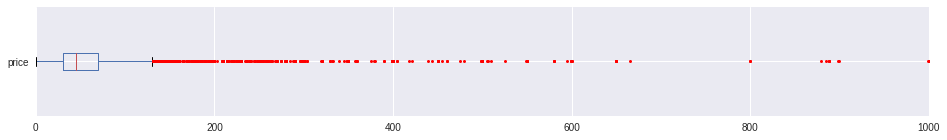

In [17]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_raw['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

A bit messy, as expected! 

75% of the apartments charge up to 68€ - but the maximum value is 9000€. Let's decide on a limit of 400€, after which the outliers seem to "fringe", and drop all records that charge more than that. Oddly enough, we have prices set to zero. So let's drop those records, too:

In [18]:
df_raw.drop(df_raw[ (df_raw.price > 400) | (df_raw.price == 0) ].index, axis=0, inplace=True)

In [19]:
df_raw['price'].describe()

count    22441.000000
mean        57.584377
std         42.162006
min          1.000000
25%         30.000000
50%         45.000000
75%         70.000000
max        400.000000
Name: price, dtype: float64

In [20]:
print("The dataset has {} rows and {} columns - after being price-wise preprocessed.".format(*df_raw.shape))

The dataset has 22441 rows and 23 columns - after being price-wise preprocessed.


*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 2.3. Dealing with Missing Values
<a id='2.3. Dealing with Missing Values'></a>

In [21]:
df_raw.isna().sum()

space                            8503
description                       202
host_has_profile_pic               25
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                          32
bedrooms                           18
bed_type                            0
amenities                           0
square_feet                     21996
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
dtype: int64

In [22]:
# drop columns with too many Nan's
df_raw.drop(columns=['square_feet', 'space'], inplace=True)

In [23]:
# drop rows with NaN's in bathrooms and bedrooms
df_raw.dropna(subset=['bathrooms', 'bedrooms', ], inplace=True)

In [24]:
df_raw.host_has_profile_pic.unique()

array(['t', 'f', nan], dtype=object)

In [25]:
# replace host_has_profile_pic Nan's with no
df_raw.host_has_profile_pic.fillna(value='f', inplace=True)
df_raw.host_has_profile_pic.unique()

array(['t', 'f'], dtype=object)

In [26]:
df_raw.isna().sum()

description                     202
host_has_profile_pic              0
neighbourhood_group_cleansed      0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
bed_type                          0
amenities                         0
price                             0
cleaning_fee                      0
security_deposit                  0
extra_people                      0
guests_included                   0
minimum_nights                    0
instant_bookable                  0
is_business_travel_ready          0
cancellation_policy               0
dtype: int64

In [27]:
print("The dataset has {} rows and {} columns - after having dealt with missing values.".format(*df_raw.shape))

The dataset has 22391 rows and 21 columns - after having dealt with missing values.


*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 2.4. Feature Engineering 1: Distance to Centroid of Berlin
<a id='2.4. Feature Engineering 1: Distance to Centroid of Berlin'></a>

Location is always an important factor in lodging services. To make it more descriptive, I decided to calculate each accommodation's distance to the so-called centroid of Berlin instead of just relying on the neighbourhoods or areas. 

For our convenience, let's write a quick function that does this, apply it to each accommodation, and store the values in a new column:

In [28]:
from geopy.distance import great_circle

In [29]:
def distance_to_mid(lat, lon):
    berlin_centre = (52.5027778, 13.404166666666667)
    accommodation = (lat, lon)
    return great_circle(berlin_centre, accommodation).km

In [30]:
df_raw['distance'] = df_raw.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [31]:
df_raw.head(2)

,description,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,amenities,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,distance
id,,,,,,,,,,,,,,,,,,,,,,
2015,Great location! 30 of 75 sq meters. This wood...,t,Mitte,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,1.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",60.0,30.0,200.0,28.0,1,4,f,f,strict_14_with_grace_period,3.533182
2695,In the summertime we are spending most of our ...,t,Pankow,52.548513,13.404553,Apartment,Private room,2,1.0,1.0,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",17.0,0.0,0.0,0.0,1,2,f,f,flexible,5.085573


*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 2.5. Feature Engineering 2: Lodging Size
<a id='2.5. Feature Engineering 2: Lodging Size'></a>

One of the most important pieces of information for predicting the rate is the size. Since the column `square_feet` was heavily filled with null values, we dropped it in the previous section. (Besides, size in Germany is expressed in square meters, not in square feet.)

Let's check, if the column `description` reveals any information about size instead: 

In [32]:
#list(df_raw.description[:10])

In [33]:
df_raw.description.isna().sum()

202

The `description` column seems to be rich in content. Let's extract 
- all double-digit or three-digit numbers 
- that are followed by one of the two characters "s" or "m" (covering "sqm", "square meters", "m2" etc.) and 
- may or may not be connected by white space. 

Single- or more than three-digit numbers for accommodation sizes are quite unlikely.

I know, it's a bold move - but let's give it a try...

***Extracting size from text***

In [34]:
# extract numbers 
df_raw['size'] = df_raw['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
df_raw['size'] = df_raw['size'].str.replace("\D", "")

# change datatype of size into float
df_raw['size'] = df_raw['size'].astype(float)

print('NaNs in size_column absolute:     ', df_raw['size'].isna().sum())
print('NaNs in size_column in percentage:', round(df_raw['size'].isna().sum()/len(df_raw),3), '%')

NaNs in size_column absolute:      11721
NaNs in size_column in percentage: 0.523 %


In [35]:
df_raw[['description', 'size']].head(10)

,description,size
id,,
2015,Great location! 30 of 75 sq meters. This wood...,75.0
2695,In the summertime we are spending most of our ...,25.0
3176,This beautiful first floor apartment is situa...,68.0
3309,First of all: I prefer short-notice bookings. ...,26.0
7071,Cozy and large room in the beautiful district ...,20.0
9991,4 bedroom with very large windows and outstand...,780.0
14325,The apartment is located on the upper second f...,NaN
16401,Hello future guests! We want to rent our cute ...,55.0
16644,Light and sunny 2-Room-turn of the century-fla...,80.0


In [36]:
#list(df_raw.description[:10])

Comparing the results, we did a pretty good job with the first 4 records, but filtered an incorrect number for the last record. Okay, let's keep that in mind: there may be mistakes in the size we engineered from the text! 

In [37]:
# drop description column
df_raw.drop(['description'], axis=1, inplace=True)

***Predicting missing values with regression***

As calculated further up, half of our records still don't have a size. That means we have a problem! Dropping these records isn't an option as we would loose too much valuable information. Simply replacing it with the mean or median makes no sense. That leaves a third option: predict the missing value with a Machine Learning Algorithm. To not make it too complicated, we'll only use numerical features. Next, we have to split our data into 
- a) a training set where we have sizes and 
- b) a test set where we don't.

In [38]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22391 entries, 2015 to 29867352
Data columns (total 22 columns):
host_has_profile_pic            22391 non-null object
neighbourhood_group_cleansed    22391 non-null object
latitude                        22391 non-null float64
longitude                       22391 non-null float64
property_type                   22391 non-null object
room_type                       22391 non-null object
accommodates                    22391 non-null int64
bathrooms                       22391 non-null float64
bedrooms                        22391 non-null float64
bed_type                        22391 non-null object
amenities                       22391 non-null object
price                           22391 non-null float64
cleaning_fee                    22391 non-null float64
security_deposit                22391 non-null float64
extra_people                    22391 non-null float64
guests_included                 22391 non-null int64
minimum_nights 

In [39]:
# filter out sub_df to work with
sub_df = df_raw[['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included', 'distance', 'size']]

In [40]:
# split datasets
train_data = sub_df[sub_df['size'].notnull()]
test_data  = sub_df[sub_df['size'].isnull()]

# define X
X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)

# define y
y_train = train_data['size']

In [41]:
print("Shape of Training Data:", train_data.shape)
print("Shape of Test Data:    ",test_data.shape)
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("\nShape of y_train:", y_train.shape)

Shape of Training Data: (10670, 10)
Shape of Test Data:     (11721, 10)

Shape of X_train: (10670, 9)
Shape of X_test: (11721, 9)

Shape of y_train: (10670,)


In [42]:
# import Linear Regression
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit model to training data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [43]:
# making predictions
y_test = linreg.predict(X_test)

Now that we have predicted the missing sizes, let's cast `y_test` into a dataframe with a column `size`:

In [44]:
y_test = pd.DataFrame(y_test)
y_test.columns = ['size']
print(y_test.shape)
y_test.head()

(11721, 1)


,size
0,56.697281
1,97.756906
2,75.831592
3,88.778838
4,60.680846


In [45]:
print(X_test.shape)
X_test.head()

(11721, 9)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance
id,,,,,,,,,
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509


To combine `y_test` and `X_test` back to our full test_dataframe, we have to create a bit of a circuit. As we can see here, the `X_test` dataframe has a specific index that's not compatible with `y_test`, where the numbers simply start from 0 onwards. So we need to provide `y_test` with the `X_test` index to make sure everyting fits together.

In [46]:
# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)
y_test.head()

,size
prelim,
14325,56.697281
20858,97.756906
21869,75.831592
22415,88.778838
28156,60.680846


In [47]:
new_test_data = pd.concat([X_test, y_test], axis=1)

In [48]:
print(new_test_data.shape)
new_test_data.head()

(11721, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297,56.697281
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207,97.756906
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292,75.831592
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255,88.778838
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509,60.680846


In [49]:
new_test_data['size'].isna().sum()

0

Once we have completed our new train_data, we stack test_data and train_data back to a new sub_dataframe across the rows:

In [50]:
# combine train and test data back to a new sub df
sub_df_new = pd.concat([new_test_data, train_data], axis=0)

print(sub_df_new.shape)
sub_df_new.head()

(22391, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297,56.697281
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207,97.756906
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292,75.831592
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255,88.778838
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509,60.680846


In [51]:
sub_df_new['size'].isna().sum()

0

Finally, the last big step: merging our sub_dataframe with the remaining columns from our original dataframe - this time, across the columns:

In [52]:
# prepare the multiple columns before concatening
df_raw.drop(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee', 
             'security_deposit', 'extra_people', 'guests_included', 'distance', 'size'], 
            axis=1, inplace=True)

In [53]:
# concate back to complete dataframe
df = pd.concat([sub_df_new, df_raw], axis=1)

print(df.shape)
df.head(2)

(22391, 22)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,bed_type,amenities,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
2015,3,1.0,1.0,60.0,30.0,200.0,28.0,1,3.533182,75.0,t,Mitte,52.534537,13.402557,Guesthouse,Entire home/apt,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",4,f,f,strict_14_with_grace_period
2695,2,1.0,1.0,17.0,0.0,0.0,0.0,1,5.085573,25.0,t,Pankow,52.548513,13.404553,Apartment,Private room,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",2,f,f,flexible


***Investigating sizes***

Let's thoroughly examine our new `size` column:

In [54]:
df['size'].isna().sum()

0

In [55]:
df['size'].describe()

count    22391.000000
mean        60.297112
std         80.937597
min          0.000000
25%         25.000000
50%         49.573940
75%         65.014837
max        980.000000
Name: size, dtype: float64

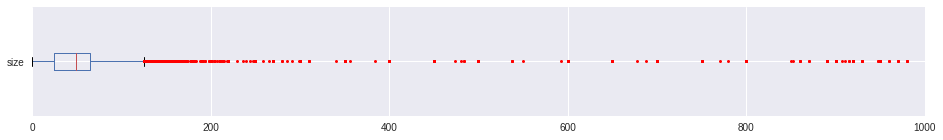

In [56]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['size'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

To be on the safe side, let’s remove all outliers over 300 square meters, and all those with 0:

In [57]:
df.drop(df[ (df['size'] == 0.) | (df['size'] > 300.) ].index, axis=0, inplace=True)

In [58]:
print("The dataset has {} rows and {} columns - after being engineered.".format(*df.shape))

The dataset has 21958 rows and 22 columns - after being engineered.


*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 2.6. Feature Engineering 3: Lodging Amenities
<a id='2.6. Feature Engineering 3: Lodging Amenities'></a>

I'm interested in what amenities hosts offer their guests, and in order to enrich our prediction, whether we can determine what some of the more special and/or rare amenities might be that make a property more desirable.

In [59]:
from collections import Counter

In [60]:
results = Counter()
df['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(30)

[('Wifi', 20952),
 ('Kitchen', 20809),
 ('Heating', 20657),
 ('Essentials', 19811),
 ('Washer', 18071),
 ('Hair dryer', 14474),
 ('Laptop friendly workspace', 14095),
 ('Hangers', 13514),
 ('Iron', 10876),
 ('Shampoo', 10339),
 ('TV', 9778),
 ('Hot water', 9421),
 ('Family/kid friendly', 7925),
 ('Internet', 7699),
 ('Host greets you', 6469),
 ('Smoke detector', 6245),
 ('Buzzer/wireless intercom', 5963),
 ('Lock on bedroom door', 5138),
 ('Free street parking', 5037),
 ('Refrigerator', 5033),
 ('Dishes and silverware', 4909),
 ('Elevator', 4703),
 ('Cooking basics', 4673),
 ('Bed linens', 4656),
 ('Stove', 4655),
 ('Smoking allowed', 4509),
 ('Oven', 4161),
 ('translation missing: en.hosting_amenity_50', 4095),
 ('First aid kit', 3866),
 ('Cable TV', 3577)]

In [61]:
# create a new dataframe
sub_df = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])

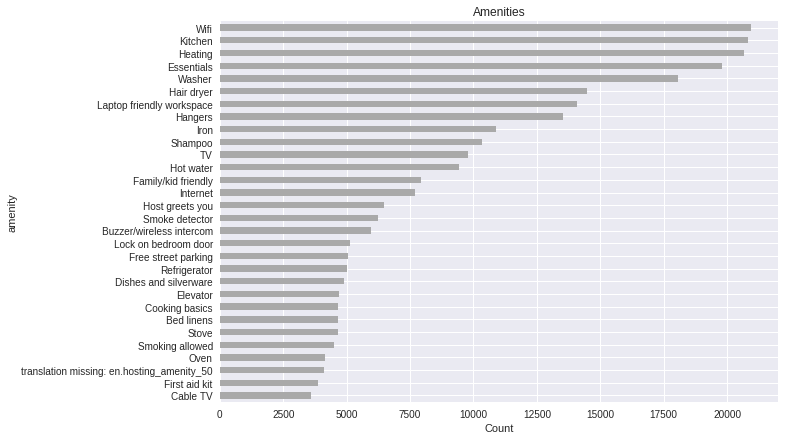

In [62]:
# plot the Top 20
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Amenities')
plt.xlabel('Count');

Let's add columns with amenities that are somewhat unique and not offered by all hosts: 
- a laptop-friendly workspace
- a TV
- kid friendly accommodation 
- smoker friendly and 
- being greeted by the host.

After doing this, let's drop the original column:

In [63]:
df['Laptop_friendly_workspace'] = df['amenities'].str.contains('Laptop friendly workspace')
df['TV'] = df['amenities'].str.contains('TV')
df['Family_kid_friendly'] = df['amenities'].str.contains('Family/kid friendly')
df['Host_greets_you'] = df['amenities'].str.contains('Host greets you')
df['Smoking_allowed'] = df['amenities'].str.contains('Smoking allowed')

In [64]:
df.drop(['amenities'], axis=1, inplace=True)

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 3. Exploratory Data Analysis (EDA)
<a id='3. Exploratory Data Analysis (EDA)' ></a>

**> Price Differences on a Map**

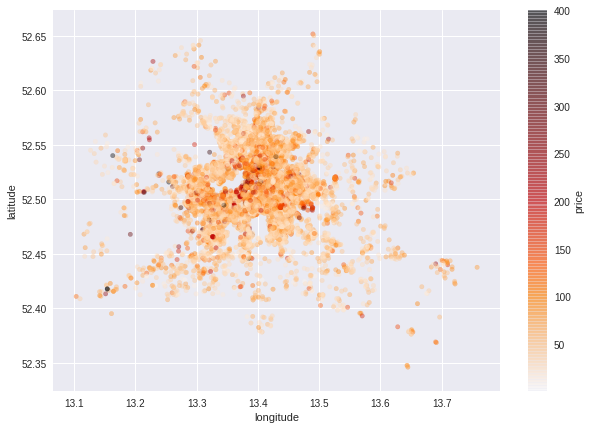

In [65]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);

**> Price Differences by Neighbourhood**

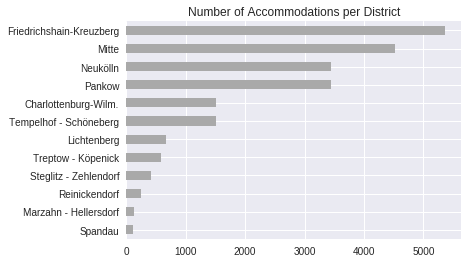

In [66]:
df['neighbourhood_group_cleansed'].value_counts().sort_values().plot(kind='barh', color='darkgrey')
plt.title('Number of Accommodations per District');

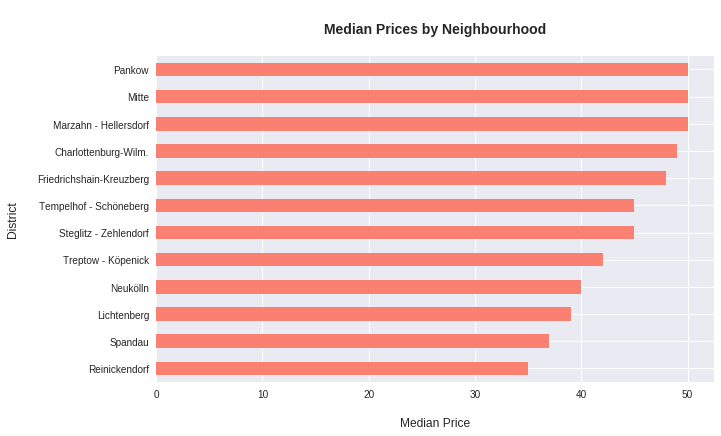

In [67]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(df.groupby(['neighbourhood_group_cleansed'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='neighbourhood_group_cleansed', y='price', 
                figsize=(10,6), legend=False, color='salmon')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nMedian Prices by Neighbourhood\n', fontsize=14, fontweight='bold');

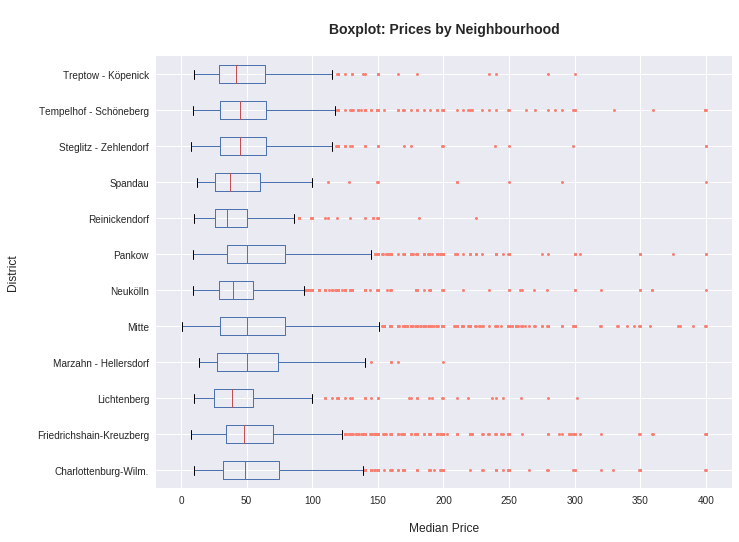

In [68]:
red_square = dict(markerfacecolor='salmon', markeredgecolor='salmon', marker='.')

df.boxplot(column='price', by='neighbourhood_group_cleansed', 
           flierprops=red_square, vert=False, figsize=(10,8))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nBoxplot: Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

# get rid of automatic boxplot title
plt.suptitle('');

**> Price Differences by Accommodation Distance to Center of Berlin**

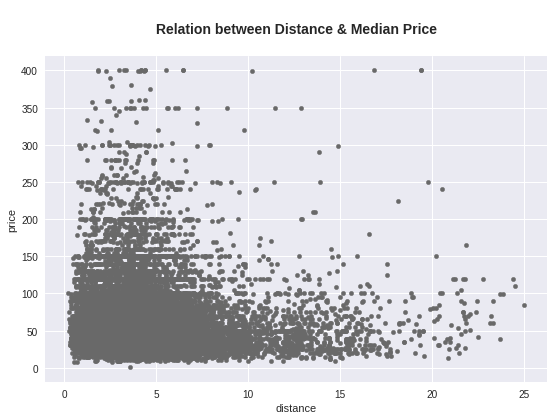

In [69]:
df.plot.scatter(x="distance", y="price", figsize=(9,6), c='dimgrey')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

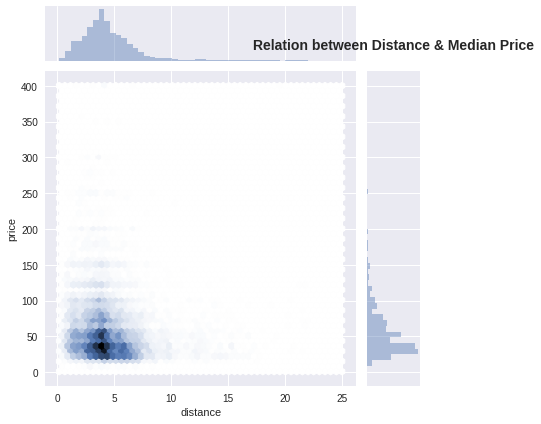

In [70]:
sns.jointplot(x=df["distance"], y=df["price"], kind='hex')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

**> Price Differences by Accommodation Size**

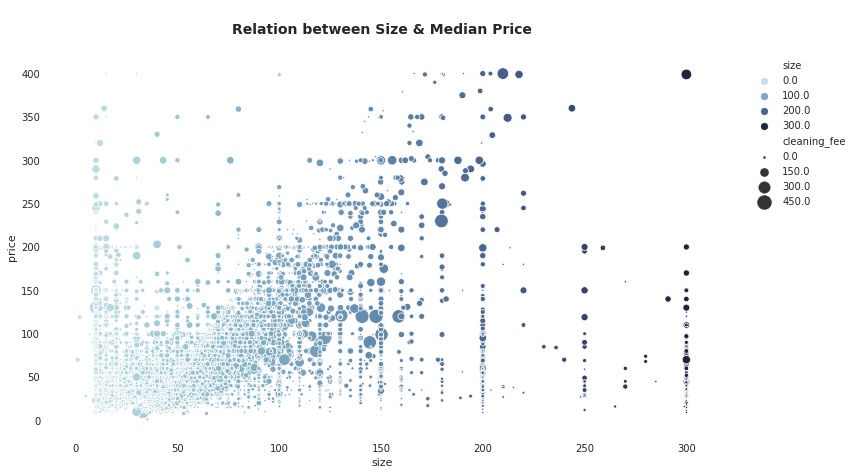

In [71]:
sns.set_style("white")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

fig, ax = plt.subplots(figsize=(12,7))
ax = sns.scatterplot(x="size", y="price", size='cleaning_fee', sizes=(5, 200),
                      hue='size', palette=cmap,  data=df)

plt.title('\nRelation between Size & Median Price\n', fontsize=14, fontweight='bold')

# putting legend out of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

**> Price Differences by Number of Bedrooms**

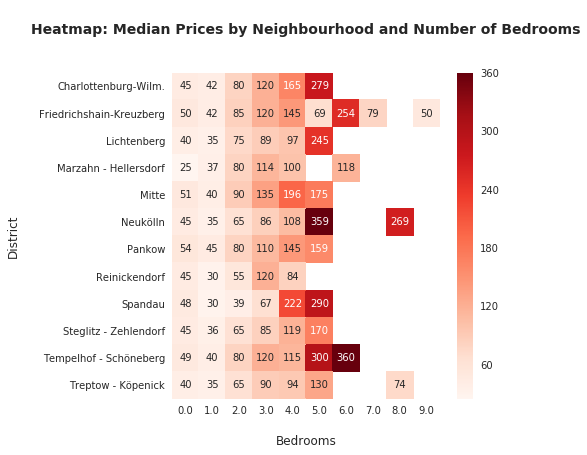

In [72]:
plt.figure(figsize=(6,6))
sns.heatmap(df.groupby(['neighbourhood_group_cleansed', 'bedrooms']).price.median().unstack(), 
            cmap='Reds', annot=True, fmt=".0f")

plt.xlabel('\nBedrooms', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nHeatmap: Median Prices by Neighbourhood and Number of Bedrooms\n\n', fontsize=14, fontweight='bold');

**> Price Differences by Cancellation Policy**

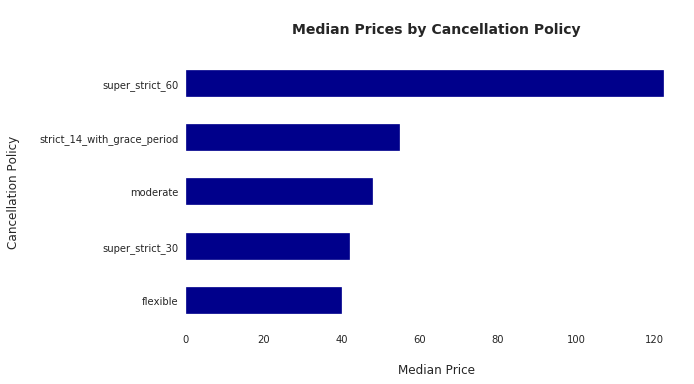

In [73]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(df.groupby(['cancellation_policy'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='cancellation_policy', y='price', 
                figsize=(9,5), legend=False, color='darkblue')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Cancellation Policy\n', fontsize=12)
plt.title('\nMedian Prices by Cancellation Policy\n', fontsize=14, fontweight='bold');

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 4. Modeling the Data 
<a id='4. Modeling the Data'></a>

#### 4.1. Preparing Target and Features
<a id='4.1. Preparing Target and Features'></a>

In [74]:
df.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee',
       'security_deposit', 'extra_people', 'guests_included', 'distance',
       'size', 'host_has_profile_pic', 'neighbourhood_group_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'bed_type',
       'minimum_nights', 'instant_bookable', 'is_business_travel_ready',
       'cancellation_policy', 'Laptop_friendly_workspace', 'TV',
       'Family_kid_friendly', 'Host_greets_you', 'Smoking_allowed'],
      dtype='object')

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21958 entries, 2015 to 29867352
Data columns (total 26 columns):
accommodates                    21958 non-null int64
bathrooms                       21958 non-null float64
bedrooms                        21958 non-null float64
price                           21958 non-null float64
cleaning_fee                    21958 non-null float64
security_deposit                21958 non-null float64
extra_people                    21958 non-null float64
guests_included                 21958 non-null int64
distance                        21958 non-null float64
size                            21958 non-null float64
host_has_profile_pic            21958 non-null object
neighbourhood_group_cleansed    21958 non-null object
latitude                        21958 non-null float64
longitude                       21958 non-null float64
property_type                   21958 non-null object
room_type                       21958 non-null object
bed_type     

As we work with the distance to the center, let's drop the `neighbourhood_group_cleansed`. Furthermore, `property_types` may not be that helpful.

In [76]:
df.drop(['latitude', 'longitude', 'neighbourhood_group_cleansed', 'property_type'], axis=1, inplace=True)

Now let's convert all string columns into categorical ones:

In [77]:
for col in ['host_has_profile_pic', 'room_type', 'bed_type', 'instant_bookable', 
            'is_business_travel_ready', 'cancellation_policy']:
    df[col] = df[col].astype('category')

In [78]:
# define our target
target = df[["price"]]

# define our features 
features = df.drop(["price"], axis=1)

***Recoding Categorical Features***

Machine learning algorithms generally need all data - including categorical data - in numeric form. To satisfy these algorithms, categorical features are converted into separate binary features called dummy variables. Therefore, we have to find a way to represent these variables as numbers before handing them off to the model. One typical way of doing this in one-hot encoding, which creates a new column for each unique category in a categorical variable. Each observation receives a 1 in the column for its corresponding category (= "HOT") and a 0 in all other new columns. To conduct one-hot encoding, we use the pandas get_dummies function.

In [79]:
num_feats = features.select_dtypes(include=['float64', 'int64', 'bool']).copy()

# one-hot encoding of categorical features
cat_feats = features.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)

In [80]:
features_recoded = pd.concat([num_feats, cat_feats], axis=1)

In [81]:
print(features_recoded.shape)
features_recoded.head(2)

(21958, 33)


,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,minimum_nights,Laptop_friendly_workspace,TV,Family_kid_friendly,Host_greets_you,Smoking_allowed,host_has_profile_pic_f,host_has_profile_pic_t,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
2015,3,1.0,1.0,30.0,200.0,28.0,1,3.533182,75.0,4,True,True,True,False,False,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0
2695,2,1.0,1.0,0.0,0.0,0.0,1,5.085573,25.0,2,True,False,False,False,False,0,1,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0


#### 4.2. Splitting and Scaling the Data
<a id='4.2. Splitting and Scaling the Data'></a>

In [82]:
# import train_test_split function
from sklearn.model_selection import train_test_split
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

# split our data
X_train, X_test, y_train, y_test = train_test_split(features_recoded, target, test_size=0.2)

One of the challenges in building models is mixing features that have different scales. Look at our dataset and compare bathrooms with size or maximum_nights. When we mix units with ranges that have different orders of magnitude, our models may not be able to find the proper coefficients. To account for this problem, we standardize or normalize the features.

In [83]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

#### 4.3. Training an XGBoost Regressor
<a id='4.3. Training an XGBoost Regressor'></a>

In [84]:
# create a baseline
booster = xgb.XGBRegressor()

Some of the important hyperparameters to tune an XGBoost are:
- `n_estimators` $\;\;\;\;\;$ = Number of trees one wants to build.
- `learning_rate` $\;\;\;\;$= Rate at which our model learns patterns in data. After every round, it shrinks the feature weights to reach the best optimum.
- `max_depth` $\;\;\;\;\;\;\;\;\;\;\;$= Determines how deeply each tree is allowed to grow during any boosting round.
- `colsample_bytree` = Percentage of features used per tree. 
- `gamma` $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$= Specifies the minimum loss reduction required to make a split.

In [85]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [86]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, 
                           max_depth=6, n_estimators=200, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

In [87]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 23.6884


In [88]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {round(r2, 4)}")

r2: 0.6718


#### 4.4. Cross Validation
<a id='4.4. Cross Validation'></a>

In order to build more robust models, it is common to conduct a k-fold cross validation where all the entries in the original training dataset are used for both training and validation. XGBoost supports k-fold cross validation via the cv method. All we have to do is specify the `nfolds` parameter, which is the number of cross validation rounds you want to build. 

Also, it supports many other parameters:
- `num_boost_round` $\;\;\;\;\;\;\;\;$ = Specifies the number of trees to build (analogous to n_estimators).
- `metrics` $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ = Specifies the evaluation metrics to be checked during CV.
- `as_pandas` $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$= Returns the results in a decent pandas DataFrame.
- `early_stopping_rounds` = Finishes model training early if the hold-out metric does not improve for a given number of rounds. 

We will have to first convert the dataset into an optimized data structure called DMatrix so that XGBoost's cross validation method is supported.

In [89]:
xg_train = xgb.DMatrix(data=X_train, label=y_train)

In [90]:
params = {'colsample_bytree':0.6, 'gamma':0.2, 'learning_rate':0.05, 'max_depth':6}

cv_results = xgb.cv(dtrain=xg_train, params=params, nfold=3,
                    num_boost_round=200, early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True)

[08:54:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[08:54:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[08:54:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[08:54:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[08:54:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[08:54:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[08:54:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[08:54:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[08:54:0

In [91]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,68.079557,0.112399,68.120809,0.224681
1,65.376694,0.088449,65.461639,0.295914
2,62.728524,0.142233,62.843457,0.319130
3,60.357433,0.127779,60.536871,0.287779
4,58.045253,0.202034,58.256260,0.247612


In [92]:
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
195,17.371501,0.250670,23.756892,0.554574
196,17.354503,0.253598,23.753743,0.553943
197,17.343564,0.256247,23.752342,0.554480
198,17.338913,0.259025,23.752326,0.554908
199,17.328927,0.265235,23.748124,0.553120


*Back to: <a href='#Table of contents'> Table of contents</a>*
### 5. Interpreting the Data 
<a id='5. Interpreting the Data'></a>

We can see that our average error (RMSE) in the initial XGBoost is around 22€, which improves to 17.5€ by cross validation. Given the fact that after cleaning up the price column, 50% of our lodgings cost only up to 45€ and 75% of our lodgings up to 70€ - even the improved standard deviation of 17€ is quite a massive inaccuracy that doesn't help much in recommending a price.

It turns out that the price is dependent not only on geography, size, and features. It stands to reason that 
- the quality of presentation (e.g. pictures), 
- availability, 
- the number and content of reviews, 
- communication (e.g. acceptance rate, host response time) or 
- status ((whether or not the host is a super host)) 

might have a substantial influence too. But the purpose of this analysis was to recommend a price to a "rookie" without any reviews or status. With this in mind, we might say that we can't recommend an exact price, but rather a range..

The next step (and maybe an idea for the reader) would be to start all over again and include the features mentioned above to try to find out if accuracy improves. That might help a beginner on Airbnb better know what price to aim for.

With what we have done here, we have explained 71% of the variance (R^2) with the most important accommodation features, as pictured below:

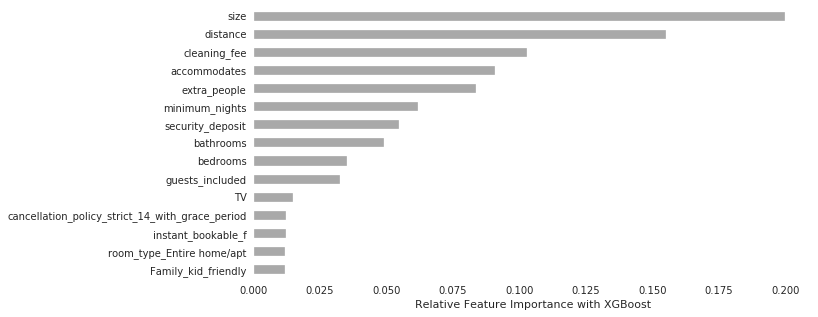

In [93]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=features_recoded.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');

As we see, the **most important features are size, distance, and cleaning fee**, which account for approximately 45% of the daily price. Other top features are the number of people the apartment accommodates, other fees such as security deposit or the price for extra people, minimum night stay and bathrooms.

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 6. Appendix 
<a id='6. Appendix'></a>

All resources used in this notebook are listed below.

Data
- http://insideairbnb.com/get-the-data.html

Imputing missing values with Linear Regression
- https://towardsdatascience.com/the-tale-of-missing-values-in-python-c96beb0e8a9d

XGBoost
- https://www.datacamp.com/community/tutorials/xgboost-in-python
- https://www.kaggle.com/marcelo06/cross-validation-with-xgboost-python

Geocoding
- https://pypi.org/project/geopy/

Centroid of Berlin (in German!)
- https://www.tagesspiegel.de/berlin/bezirke/friedrichshain-kreuzberg/reise-zum-mittelpunkt-berlins-am-ruhepol/9837502.html

Visualizations
- https://python-graph-gallery.com
- https://www.kaggle.com/kostyabahshetsyan/boston-airbnb-visualization

Inspiration for Analysis
- https://towardsdatascience.com/digging-into-airbnb-data-reviews-sentiments-superhosts-and-prices-prediction-part1-6c80ccb26c6a
- https://www.kaggle.com/mathvv/prediction-on-house-prices-xgboost-tutorial
- https://towardsdatascience.com/improving-airbnb-yield-prediction-with-text-mining-9472c0181731
- https://github.com/joaeechew/airbnb_nlp/blob/master/Capstone%20Project.ipynb